In [17]:
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.datasets import make_moons, make_blobs
from IPython.display import HTML #we need this for displaying an animation when using an .ipynb file

In [18]:
import candle.nn as nn
import candle.losses as losses
import candle.helpers as helpers
from candle.engine import Scalar, Vector

In [38]:
random.seed(42)

First, we will download and visualize a dataset. 

First five X values:
 [[ 1.0553778   0.40435384]
 [ 0.73307479  0.61493781]
 [ 1.97545684 -0.07817622]
 [ 0.29093728  0.88473743]
 [ 0.84686451  0.71657311]]

First five y values:
 [-1 -1  1 -1 -1]


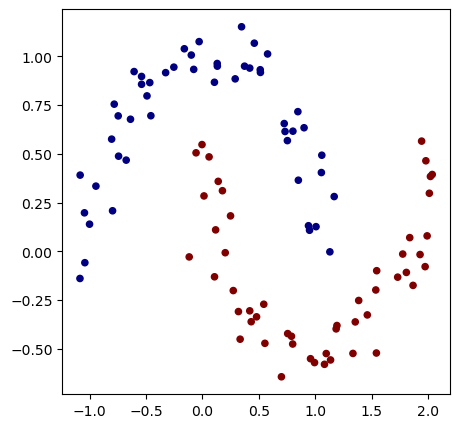

In [39]:
# First, we will download and visualize a dataset in 2D
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1     # make y be -1 or 1 (instead of 0 or 1)
print(f"First five X values:\n {X[:5]}\n")
print(f"First five y values:\n {y[:5]}")
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

Now, we will instantiate the model and the training data using PyCandle. 

In [40]:
model = nn.MLP(2, [16, 16, 1], activ='tanh') # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

Xs = [Vector(x) for x in X]
ys = Vector(y)

number of parameters 337


We also need to define some information for plotting predicted contours later on

In [41]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [Vector(xrow) for xrow in Xmesh]
Zs = []

Let's train!

In [42]:
for epoch in range(50):

    # Forward pass
    model.zero_grad()
    y_preds = list(map(model, Xs))
    loss = losses.mean_squared_error(ys, y_preds)

    # Back propagation
    loss.backward()

    # Gradient descent (using the entire training set)
    learning_rate = 1.0 - 0.9*epoch/100 # 
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    print(epoch, loss.data)

    # Calculating predicted contour
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)
    Zs.append(Z)


0 1.5214905046981013
1 1.0980709986257102
2 0.8789012000139775
3 0.8532095440399623
4 0.744430096141675
5 0.6808046363986051
6 0.6776327720845802
7 0.6769033645874724
8 0.6711771657626363
9 0.6658942221867341
10 0.675114037268766
11 0.6658136675976971
12 0.6372458062207178
13 0.6362650502998485
14 0.6336251594643176
15 0.6686321625375181
16 0.5623691451521446
17 0.5001877539211393
18 0.5134216297767505
19 0.5030066534686525
20 0.4662985057871334
21 0.4764710408785792
22 0.46384456358017717
23 0.44179534511605617
24 0.4250884283553856
25 0.36443126469457915
26 0.29654494515872637
27 0.2581453407847433
28 0.2476683274930428
29 0.25822507419972895
30 0.38231593329267155
31 0.3960661306498205
32 0.24862992168399708
33 0.18563316519005987
34 0.3413431915972865
35 0.21251941380256484
36 0.13520508452805044
37 0.2200203639686244
38 0.08932995486469433
39 0.15295112460428786
40 0.24722987987498088
41 0.11749501904187006
42 0.10519115426842866
43 0.15777223607495186
44 0.028412854721451507
45 0

Since we stored predictions of a background meshgrid for each epoch during training (`Zs`), we can visualize how the model learned over time.

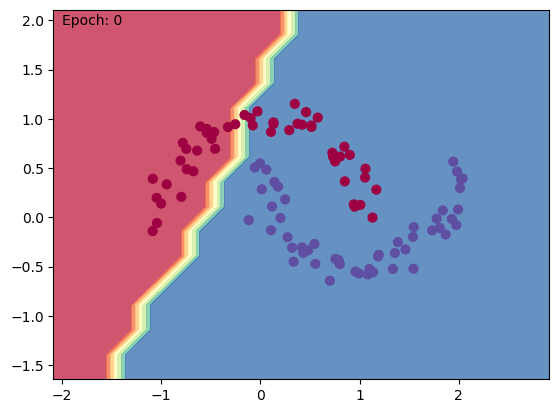

In [51]:
fig, ax = plt.subplots()
cf = ax.contourf(xx, yy, Zs[0], cmap=plt.cm.Spectral, alpha=0.8)
sct = ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
txt = ax.text(-2.0,2.0, f"Epoch: 0", va='center')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max()) 

def animate(i):
    global cf
    for coll in cf.collections:
        coll.remove()
    Z = Zs[i]
    cf = ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    sct = ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    txt.set_text(f"Epoch: {i}")   

    return cf

anim = animation.FuncAnimation(fig, animate, frames=len(Zs), repeat=False)

plt.show()
HTML(anim.to_html5_video())